### Import libraries and modify notebook settings

In [2]:
# Import libraries
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from pysndfx import AudioEffectsChain
from IPython.display import Audio, display

# Modify notebook settings
%matplotlib inline

### Create paths to data folders and files

In [3]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save path to the raw metadata file
# "UrbanSound8K.csv"
metadata_file = os.path.join(proj_root,
                             "data",
                             "raw",
                             "UrbanSound8K",
                             "metadata",
                             "UrbanSound8K.csv")

# Save path to the raw audio files
raw_audio_path = os.path.join(proj_root,
                             "data",
                             "raw",
                             "UrbanSound8K",
                             "audio")

# Save the path to the folder that will contain 
# the interim data sets for modeling:
# /data/interim
interim_data_dir = os.path.join(proj_root,
                                "data",
                                "interim")

# Save path to the folder for the
# spectrogram arrays that we will generate
spectrogram_arrays_path = os.path.join(interim_data_dir,
                                       "spectrogram_arrays")


In [4]:
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(proj_root, "src")
sys.path.append(src_dir)

### Inspect  `df_interim` and `df_class_key`  csv files.

In [5]:
new_file_name = 'metadata_train.csv'
new_file_path = os.path.join(interim_data_dir,
                             new_file_name)
df_train = pd.read_csv(new_file_path)

df_train.head()

,Unnamed: 0,classID,slice_file_name,fold,test_data
0,0,3,101415-3-0-2.wav,1,False
1,1,3,101415-3-0-3.wav,1,False
2,2,3,101415-3-0-8.wav,1,False
3,3,3,102842-3-0-1.wav,1,False
4,4,3,102842-3-1-0.wav,1,False


In [6]:
new_file_name = 'classID_key.csv'
new_file_path = os.path.join(interim_data_dir,
                             new_file_name)

df_class_key = pd.read_csv(new_file_path)

df_class_key.head()

,Unnamed: 0,class,classID
0,0,air_conditioner,0
1,1,car_horn,1
2,2,children_playing,2
3,3,dog_bark,3
4,4,drilling,4


## Process audio files

In [7]:
df_train.head()

,Unnamed: 0,classID,slice_file_name,fold,test_data
0,0,3,101415-3-0-2.wav,1,False
1,1,3,101415-3-0-3.wav,1,False
2,2,3,101415-3-0-8.wav,1,False
3,3,3,102842-3-0-1.wav,1,False
4,4,3,102842-3-1-0.wav,1,False


In [8]:
global_sr = 22050
global_n_mels = 128 # 96
global_spec_w = 128 # spectrogram width
smooth_sec = 0.5    # number of seconds of smoothing for background noise

pitch_shift_list = [None, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3]
time_stretch_list = [None, 0.90, 0.95, 1.05, 1.10]
background_noise_list = [None, 1, 2]

# make targets fuzzy

In [9]:
len(pitch_shift_list) * len(time_stretch_list) * 2 * 3

390

In [10]:
len(df_train)

5740

In [11]:
samples_new = len(df_train) * len(pitch_shift_list) * len(time_stretch_list) * 2 * 3
print('{:,}'.format(samples_new))

2,238,600


In [12]:
samples_old = 86100
size_old = 4.82 # GB
samples_new / samples_old
size_old * samples_new / samples_old

125.32

In [13]:
samples_new / samples_old

26.0

In [14]:
for index, row in df_train.iterrows():

    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                             fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    ############
    classID = row['classID']
    
    # Second randomly sampled audio_file from same classID
    row_2  = df_train[df_train.classID == classID].sample()
    
    fold_name_2 = 'fold' + str(row_2['fold'].values[0])
    fold_path_2 = os.path.join(raw_audio_path,
                               fold_name_2)
        
    # Full path to the audio_file
    audio_file_2 = row_2['slice_file_name'].values[0]
    audio_path_2 = os.path.join(fold_path_2,
                                audio_file_2)
        
    # Load the .wav audio_file_2
    aud_array_2, sr_2 = librosa.load(audio_path_2, sr=global_sr)
    
    
    if index >= 1:
        break
        

In [15]:
audio_path

'../data/raw/UrbanSound8K/audio/fold1/101415-3-0-3.wav'

In [17]:
aud_array.shape

(88200,)

In [19]:
Audio(filename=audio_path)

In [21]:
Audio(data=aud_array, rate=global_sr)

In [28]:
#np.random.seed(42)

count = 0

for index, row in df_train.iterrows():
    
    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                         fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    for bn in background_noise_list:   
        
        if bn is not None:
        
            classID = row['classID']

            # Second randomly sampled audio_file from same classID
            row_2  = df_train[df_train.classID == classID].sample()

            fold_name_2 = 'fold' + str(row_2['fold'].values[0])
            fold_path_2 = os.path.join(raw_audio_path,
                                       fold_name_2)

            # Full path to the audio_file
            audio_file_2 = row_2['slice_file_name'].values[0]
            audio_path_2 = os.path.join(fold_path_2,
                                        audio_file_2)

            # Load the .wav audio_file_2
            aud_array_2, sr_2 = librosa.load(audio_path_2, sr=global_sr)

            # Smoothing array for background noise
            stub_int = int((global_sr / 2))
            smooth_array = np.ones(aud_array.shape)
            smooth_array[:stub_int] = np.sin(np.linspace((-0.5 * np.pi), (0.5 * np.pi), stub_int))
            smooth_array[-stub_int:] = np.sin(np.linspace((-1.5 * np.pi), (-0.5 * np.pi), stub_int))            
            smooth_array = (-smooth_array - 1) / -2
            
            # Smooth edges background noise
            aud_array_2 = aud_array_2 * smooth_array
            
        for ps in pitch_shift_list:
            for ts in time_stretch_list:

                aud_array_aug = aud_array

                # Pitch shift
                if ps is not None:
                    aud_array_aug = librosa.effects.pitch_shift(aud_array_aug, global_sr, n_steps=ps)

                # Time stretch
                if ts is not None:
                    aud_array_aug = librosa.effects.time_stretch(aud_array_aug, rate=ts)

                if bn is not None:
                
                    # Random time-shift background noise
                    n_shift = np.random.randint(0, (global_sr * 4))
                    mix_rate = np.random.uniform(low=0.1, high=0.5)
                    
                    aud_array_2_aug = np.roll(aud_array_2, n_shift)
                    
                    aud_array_2_aug = librosa.effects.pitch_shift(aud_array_2_aug, global_sr, 
                                                                  n_steps=np.random.uniform(-3, 3))

                    # Time stretch
                    if ts is not None:
                        aud_array_2_aug = librosa.effects.time_stretch(aud_array_2_aug, rate=ts)
                    
                        aud_array_mix = ((1 - mix_rate) * aud_array_aug) + \
                                        (mix_rate * aud_array_2_aug)    

                        aud_array_aug = aud_array_mix
                    
                # Create spectrogram array
                spec_array = librosa.logamplitude(\
                                librosa.feature.melspectrogram(aud_array_aug, 
                                                               sr=global_sr,
                                                               n_mels=global_n_mels),
                                                  ref_power=1.0)[np.newaxis,:,:,
                                                                 np.newaxis]
                
                spec_array_full = spec_array

                # Convert spectrogram array from dtype float64 to float32
                spec_array_full = spec_array_full.astype('float32')

                # Left slice            
                spec_array = spec_array_full[:,:,:global_spec_w,:]


                # Write to the hdf5 file
#                with h5py.File(train_hdf5_path, "r+") as f:
#                    # X_train
#                    dset = f['spectrogram_arrays_X_train']    
#                    # limit tensor height to 173 (there were a few tensors with 174)
#                    dset[count,:,:,:] = spec_array[:,:,:173,:]
#                    # y_train
#                    dset = f['spectrogram_arrays_y_train']    
#                    dset[count,:] = row['classID']

                count += 1

                # Right slice            
                spec_array = spec_array_full[:,:,-global_spec_w:,:]

                # Write to the hdf5 file
#                with h5py.File(train_hdf5_path, "r+") as f:
#                    # X_train
#                    dset = f['spectrogram_arrays_X_train']    
#                    # limit tensor height to 173 (there were a few tensors with 174)
#                    dset[count,:,:,:] = spec_array[:,:,:173,:]
#                    # y_train
#                    dset = f['spectrogram_arrays_y_train']    
#                    dset[count,:] = row['classID']
#                    
                count += 1

                
                ##########
#                print(count)
                break_count = 1
                if count >= break_count:
                    break
            if count >= break_count:
                break
        if count >= break_count:
            break
    if count >= break_count:
        break

    if index >= 1:
        break
                        


In [29]:
print(count)
print(mix_rate)
print('bn', bn)
print('ps', ps)
print('ts', ts)
display(Audio(data=aud_array, rate=global_sr))
display(Audio(data=aud_array_2, rate=global_sr))
display(Audio(data=aud_array_2_aug, rate=global_sr))
display(Audio(data=aud_array_aug, rate=global_sr))


2


NameError: name 'mix_rate' is not defined

In [ ]:
n_shift

In [ ]:
spec_array.shape

In [ ]:
print(count)
print(mix_rate)
print('bn', bn)
print('ps', ps)
print('ts', ts)
display(Audio(data=aud_array, rate=global_sr))
display(Audio(data=aud_array_2, rate=global_sr))
display(Audio(data=aud_array_2_aug, rate=global_sr))
display(Audio(data=aud_array_aug, rate=global_sr))


In [ ]:
print(count)
print(mix_rate)
print('bn', bn)
print('ps', ps)
print('ts', ts)
display(Audio(data=aud_array, rate=global_sr))
display(Audio(data=aud_array_2, rate=global_sr))
display(Audio(data=aud_array_2_aug, rate=global_sr))
display(Audio(data=aud_array_aug, rate=global_sr))


In [ ]:
audio_path_2

# Use fuzzy target `y`

See example: '../data/raw/UrbanSound8K/audio/fold8/70168-3-1-20.wav'

This is supposed to be a dog. It sounds more like birds. The dog is barely audible, faintly heard in the background.

In [ ]:
stub_int = int((global_sr / 2))
smooth_array = np.ones(aud_array.shape)
smooth_array[:stub_int] = np.sin(np.linspace((-0.5 * np.pi), (0.5 * np.pi), stub_int))
smooth_array[-stub_int:] = np.sin(np.linspace((-1.5 * np.pi), (-0.5 * np.pi), stub_int))            
smooth_array = (-smooth_array - 1) / -2

plt.plot(smooth_array)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [ ]:
for index, row in df_train.iterrows():

    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                             fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    ############
    classID = row['classID']
    
    # Second randomly sampled audio_file from same classID
    row_2  = df_train[df_train.classID == classID].sample()
    
    fold_name_2 = 'fold' + str(row_2['fold'].values[0])
    fold_path_2 = os.path.join(raw_audio_path,
                               fold_name_2)
        
    # Full path to the audio_file
    audio_file_2 = row_2['slice_file_name'].values[0]
    audio_path_2 = os.path.join(fold_path_2,
                                audio_file_2)
        
    # Load the .wav audio_file_2
    aud_array_2, sr_2 = librosa.load(audio_path_2, sr=global_sr)
    
    
    if index >= 1:
        break
        

In [ ]:
count = 0

for ps in pitch_shift_list:
    for ts in time_stretch_list:
        for nb in background_noise_list:        

            aud_array_aug = aud_array


            # Pitch shift
            if ps is not None:
                aud_array_aug = librosa.effects.pitch_shift(aud_array_aug, global_sr, n_steps=ps)

            # Time stretch
            if ts is not None:
                aud_array_aug = librosa.effects.time_stretch(aud_array_aug, rate=ts)

            # Create spectrogram array
            spec_array = librosa.logamplitude(\
                            librosa.feature.melspectrogram(aud_array_aug, 
                                                           sr=global_sr,
                                                           n_mels=global_n_mels),
                                              ref_power=1.0)[np.newaxis,:,:,
                                                             np.newaxis]

            # Time stretch
            if ts is not None:

                spec_array_full = spec_array

                # Left slice            
                spec_array = spec_array_full[:,:,:173,:]
    #            print(spec_array.shape)

                plt.figure()
                img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
                title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: Left'
                plt.title(title)            
                plt.axis('off')

                count += 1

                # Right slice            
                spec_array = spec_array_full[:,:,-173:,:]
    #            print(spec_array.shape)

                plt.figure()
                img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
                title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: Right'
                plt.title(title)
                plt.axis('off')

                count += 1

            else:

                spec_array = spec_array[:,:,:173,:]
    #            print(spec_array.shape)

    #            plt.figure()
    #            img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
    #            title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: N/A'
    #            plt.title(title)
    #            plt.axis('off')

                count += 1

print(count)
print('{:,}'.format(count * len(df_train)))

In [ ]:
len(pitch_shift_list) * len(time_stretch_list) * len(background_noise_list) * 2

In [ ]:
samples_new = len(df_train) * len(pitch_shift_list) * \
                len(time_stretch_list) *  len(background_noise_list) *2

In [ ]:
samples_old = 86100
size_old = 4.82 # GB
samples_new / samples_old
size_old * samples_new / samples_old

In [30]:
for index, row in df_train.iterrows():

    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                             fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    ############
    classID = row['classID']
    
    # Second randomly sampled audio_file from same classID
    row_2  = df_train[df_train.classID == classID].sample()
    
    fold_name_2 = 'fold' + str(row_2['fold'].values[0])
    fold_path_2 = os.path.join(raw_audio_path,
                               fold_name_2)
        
    # Full path to the audio_file
    audio_file_2 = row_2['slice_file_name'].values[0]
    audio_path_2 = os.path.join(fold_path_2,
                                audio_file_2)
        
    # Load the .wav audio_file_2
    aud_array_2, sr_2 = librosa.load(audio_path_2, sr=global_sr)
    
    
    if index >= 1:
        break
        

and w is a weighting parameter that was chosen randomly for each mix from a uniform distribution in the range [0.1, 0.5].

In [32]:
mix_rate = np.random.uniform(low=0.1, high=0.5)

aud_array_mix = ((1 - mix_rate) * aud_array) + \
                (mix_rate * aud_array_2)

In [33]:
mix_rate

0.49203037738872923

In [34]:
display(Audio(data=aud_array, rate=global_sr))
display(Audio(data=aud_array_2, rate=global_sr))
display(Audio(data=aud_array_mix, rate=global_sr))

fade in

In [ ]:
aud_array.shape

In [ ]:
stub_int = int((global_sr / 2))

new_array = np.ones(aud_array.shape)
new_array[:stub_int] = np.sin(np.linspace((-0.5 * np.pi), (0.5 * np.pi), stub_int))
new_array[-stub_int:] = np.sin(np.linspace((-1.5 * np.pi), (-0.5 * np.pi), stub_int))
#new_array[stub_int] = np.sin(np.linspace((-0.5 * np.pi), (0.5 * np.pi), stub_int))
#new_array[(-stub_int - 1):] = np.sin(np.linspace((-1.5 * np.pi), (-0.5 * np.pi), stub_int))

plt.plot(new_array)
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [ ]:
aud_array_trim = aud_array_mix * new_array

In [37]:
audio_path
aud_array, sr = librosa.load(audio_path, sr=global_sr)
display(Audio(data=aud_array, rate=global_sr))


In [ ]:
# Create spectrogram array
spec_array = librosa.logamplitude(\
                librosa.feature.melspectrogram(aud_array_mix, 
                                               sr=global_sr,
                                               n_mels=global_n_mels),
                                  ref_power=1.0)[np.newaxis,:,:,
                                                 np.newaxis]

In [ ]:
print('aud_array_mix', '\t\t',
      'spec_array')
print(aud_array_mix.shape, '\t\t', 
      spec_array.shape)
print('{:,} bytes'.format(sys.getsizeof(aud_array_mix)), '\t\t',
      '{:,} bytes'.format(sys.getsizeof(spec_array)))

In [ ]:
print('aud_array_mix', '\t\t',
      'spec_array')
print(aud_array_mix.shape, '\t\t', 
      spec_array.shape)
print('{:,} bytes'.format(sys.getsizeof(aud_array_mix.astype('float32'))), '\t\t',
      '{:,} bytes'.format(sys.getsizeof(spec_array.astype('float32'))))

In [ ]:
np.product(np.array(spec_array.shape))

In [ ]:
plt.figure()
img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
#title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: N/A'
#plt.title(title)
plt.axis('off')

In [ ]:
(173/4) * 4

In [ ]:
(4/173) * 128

In [ ]:
for index, row in df_train.iterrows():

    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                             fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    
    if index >= 1:
        break
        

In [ ]:
audio_path

In [ ]:
Audio(data=audio_path, rate=global_sr)

In [ ]:
aud_array

In [ ]:
n_shift = global_sr
aud_array_sft = np.roll(aud_array, n_shift)
aud_array_sft[:n_shift] = 0.0

In [ ]:
mix_rate = 0.1

aud_array_delay = ((1 - mix_rate) * aud_array) + (mix_rate * aud_array_sft)

In [ ]:
display(Audio(data=aud_array_delay, rate=global_sr))
display(Audio(data=aud_array_delay, rate=global_sr))

In [ ]:
np.random.uniform(low=0.0, high=1.0)

In [ ]:
count = 0

for ps in pitch_shift_list:
    for ts in time_stretch_list:

        aud_array_aug = aud_array

        
        # Pitch shift
        if ps is not None:
            aud_array_aug = librosa.effects.pitch_shift(aud_array_aug, global_sr, n_steps=ps)

        # Time stretch
        if ts is not None:
            aud_array_aug = librosa.effects.time_stretch(aud_array_aug, rate=ts)

        # Create spectrogram array
        spec_array = librosa.logamplitude(\
                        librosa.feature.melspectrogram(aud_array_aug, 
                                                       sr=global_sr,
                                                       n_mels=global_n_mels),
                                          ref_power=1.0)[np.newaxis,:,:,
                                                         np.newaxis]
        
        # Time stretch
        if ts is not None:
            
            spec_array_full = spec_array
            
            # Left slice            
            spec_array = spec_array_full[:,:,:173,:]
#            print(spec_array.shape)
            
            plt.figure()
            img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
            title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: Left'
            plt.title(title)            
            plt.axis('off')

            count += 1
            
            # Right slice            
            spec_array = spec_array_full[:,:,-173:,:]
#            print(spec_array.shape)
            
            plt.figure()
            img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
            title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: Right'
            plt.title(title)
            plt.axis('off')

            count += 1
            
        else:
            
            spec_array = spec_array[:,:,:173,:]
#            print(spec_array.shape)
            
            plt.figure()
            img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
            title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: N/A'
            plt.title(title)
            plt.axis('off')

            count += 1
            
print(count)
print('{:,}'.format(count * len(df_train)))

In [ ]:
train_len = count * len(df_train)
train_len

In [ ]:
test_len = len(df_test)
test_len

### Create an `.hdf5` file to store spectrogram data we will generate from the `.wav` files.

Determine the size of the dataset

In [ ]:
# Test set
dset_shape_X_test = (test_len, 96, 173,  1)
dset_shape_y_test = (test_len, 1)
print('dset_shape_X_test:\t', dset_shape_X_test)
print('dset_shape_y_test:\t', dset_shape_y_test)

# Train set
dset_shape_X_train = (train_len, 96, 173,  1)
dset_shape_y_train = (train_len, 1)
print('dset_shape_X_train:\t', dset_shape_X_train)
print('dset_shape_y_train:\t', dset_shape_y_train)

In [ ]:
# Full path for test_hdf5_path
test_hdf5_path = os.path.join(spectrogram_arrays_path,
                                "spectrogram_arrays_test.hdf5")

with h5py.File(test_hdf5_path, 'w') as f:
    f.create_dataset("spectrogram_arrays_X_test", 
                     shape=dset_shape_X_test, 
                     dtype='float32',
                     data=np.zeros(dset_shape_X_test, dtype='float32'),
                     chunks=(1, 96, 173, 1),
                     compression="gzip")
    
    f.create_dataset("spectrogram_arrays_y_test", 
                     shape=dset_shape_y_test, 
                     dtype='int8',
                     data=np.zeros(dset_shape_y_test, dtype='int8'),
                     compression="gzip")
    
# Full path for train_hdf5_path
train_hdf5_path = os.path.join(spectrogram_arrays_path,
                                "spectrogram_arrays_train.hdf5")

with h5py.File(train_hdf5_path, 'w') as f:
    f.create_dataset("spectrogram_arrays_X_train", 
                     shape=dset_shape_X_train, 
                     dtype='float32',
                     data=np.zeros(dset_shape_X_train, dtype='float32'),
                     chunks=(1, 96, 173, 1),
                     compression="gzip")
    
    f.create_dataset("spectrogram_arrays_y_train", 
                     shape=dset_shape_y_train, 
                     dtype='int8',
                     data=np.zeros(dset_shape_y_train, dtype='int8'),
                     compression="gzip")        

### Generate data for spectrogram_arrays_X_test & spectrogram_arrays_y_test

In [ ]:
count = 0

for index, row in df_test.iterrows():

    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                         fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    # Create spectrogram array
    spec_array = librosa.logamplitude(\
                    librosa.feature.melspectrogram(aud_array, 
                                                   sr=global_sr,
                                                   n_mels=global_n_mels),
                                      ref_power=1.0)[np.newaxis,:,:,
                                                     np.newaxis]
    
    # Convert spectrogram array from dtype float64 to float32
    spec_array = spec_array.astype('float32')

    # Write to the hdf5 file
    with h5py.File(test_hdf5_path, "r+") as f:
        # X_train
        dset = f['spectrogram_arrays_X_test']    
        # limit tensor height to 173 (there were a few tensors with 174)
        dset[count,:,:,:] = spec_array[:,:,:173,:]
        # y_train
        dset = f['spectrogram_arrays_y_test']    
        dset[count,:] = row['classID']

        count += 1        

### Generate data for spectrogram_arrays_X_train & spectrogram_arrays_y_train

In [ ]:
count = 0

for index, row in df_train.iterrows():
    
    # Save path to the raw audio files
    fold_name = 'fold' + str(row['fold'])
    fold_path = os.path.join(raw_audio_path,
                         fold_name)
    
    # Full path to the audio_file
    audio_file = row['slice_file_name']
    audio_path = os.path.join(fold_path,
                              audio_file)
        
    # Load the .wav audio_file
    aud_array, sr = librosa.load(audio_path, sr=global_sr)

    for ps in pitch_shift_list:
        for ts in time_stretch_list:

            aud_array_aug = aud_array

            # Pitch shift
            if ps is not None:
                aud_array_aug = librosa.effects.pitch_shift(aud_array_aug, global_sr, n_steps=ps)

            # Time stretch
            if ts is not None:
                aud_array_aug = librosa.effects.time_stretch(aud_array_aug, rate=ts)

            # Create spectrogram array
            spec_array = librosa.logamplitude(\
                            librosa.feature.melspectrogram(aud_array_aug, 
                                                           sr=global_sr,
                                                           n_mels=global_n_mels),
                                              ref_power=1.0)[np.newaxis,:,:,
                                                             np.newaxis]

            # Time stretch
            if ts is not None:

                spec_array_full = spec_array

                # Left slice            
                spec_array = spec_array_full[:,:,:173,:]
    
                # Convert spectrogram array from dtype float64 to float32
                spec_array = spec_array.astype('float32')

                # Write to the hdf5 file
                with h5py.File(train_hdf5_path, "r+") as f:
                    # X_train
                    dset = f['spectrogram_arrays_X_train']    
                    # limit tensor height to 173 (there were a few tensors with 174)
                    dset[count,:,:,:] = spec_array[:,:,:173,:]
                    # y_train
                    dset = f['spectrogram_arrays_y_train']    
                    dset[count,:] = row['classID']
                    
                count += 1
    
                # Right slice            
                spec_array = spec_array_full[:,:,-173:,:]

                # Convert spectrogram array from dtype float64 to float32
                spec_array = spec_array.astype('float32')

                # Write to the hdf5 file
                with h5py.File(train_hdf5_path, "r+") as f:
                    # X_train
                    dset = f['spectrogram_arrays_X_train']    
                    # limit tensor height to 173 (there were a few tensors with 174)
                    dset[count,:,:,:] = spec_array[:,:,:173,:]
                    # y_train
                    dset = f['spectrogram_arrays_y_train']    
                    dset[count,:] = row['classID']
                    
                count += 1
    
            else:

                spec_array = spec_array[:,:,:173,:]

                # Convert spectrogram array from dtype float64 to float32
                spec_array = spec_array.astype('float32')

                # Write to the hdf5 file
                with h5py.File(train_hdf5_path, "r+") as f:
                    # X_train
                    dset = f['spectrogram_arrays_X_train']    
                    # limit tensor height to 173 (there were a few tensors with 174)
                    dset[count,:,:,:] = spec_array[:,:,:173,:]
                    # y_train
                    dset = f['spectrogram_arrays_y_train']    
                    dset[count,:] = row['classID']
                    
                count += 1


# Inspect `HDF5` data

In [ ]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.dtype)
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.dtype)    

with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.dtype)
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.dtype)        

In [ ]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.shape)
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.shape)
    
with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.shape)
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.shape)
        

In [ ]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.ndim)
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.ndim)
    
with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.ndim)
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.ndim)
        

In [ ]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.len())
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.len())
    
with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.len())
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.len())
        

In [ ]:
with h5py.File(train_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_train']    
    print(dset.maxshape)
    
    dset = f['spectrogram_arrays_y_train']    
    print(dset.len())
    
with h5py.File(test_hdf5_path, "r") as f:
    dset = f['spectrogram_arrays_X_test']    
    print(dset.len())
    
    dset = f['spectrogram_arrays_y_test']    
    print(dset.len())
        

# import pysndfx

Install with pip as:

    $ pip install pysndfx

The system must also have SoX installed (for Debian-based operating systems: apt install sox, or with Anaconda as conda install -c conda-forge sox)

    $ conda install -c conda-forge sox

https://github.com/BVLC/caffe/issues/3806

Thank you. Your suggestion works for me. Everything worked after I ran the command below:

    brew link --overwrite libpng
    
https://stackoverflow.com/questions/22631026/dyld-library-not-loaded-usr-local-lib-libpng16-16-dylib-with-anything-php-rel

    brew update && brew upgrade
    
https://developerjack.com/blog/2016/installing-php71-with-homebrew/

    brew install php71    
    
https://github.com/Homebrew/homebrew-php/issues/3961
    
    brew reinstall -s php71
    
    
https://superuser.com/questions/421153/how-to-add-a-mp3-handler-to-sox/421168

    # install sox/lame
    sudo apt-get install sox
    sudo apt-get install lame    
    
...

    #conda install -c conda-forge sox
    #conda install lame
    
https://anaconda.org/groakat/lame

    conda install -c groakat lame 
    
https://superuser.com/questions/246918/why-isnt-sox-able-to-convert-to-mp3    
    
    brew install lame
    brew reinstall sox --with-lame # or "brew install sox" if you don't already have it installed
    

In [51]:
help(AudioEffectsChain)

Help on class AudioEffectsChain in module pysndfx.dsp:

class AudioEffectsChain(builtins.object)
 |  Methods defined here:
 |  
 |  __call__(self, src, dst=<class 'numpy.ndarray'>, sample_in=44100, sample_out=None, encoding_out=None, channels_out=None, allow_clipping=True)
 |      Call self as a function.
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  bandpass(self, frequency, q=1.0)
 |  
 |  bandreject(self, frequency, q=1.0)
 |  
 |  bend(self, bends, frame_rate=None, over_sample=None)
 |  
 |  chorus(self, gain_in, gain_out, decays)
 |  
 |  compand(self, attack=0.05, decay=0.5)
 |  
 |  delay(self, gain_in=0.8, gain_out=0.5, delays=[1000, 1800], decays=[0.3, 0.25], parallel=False)
 |  
 |  echo(self, **kwargs)
 |  
 |  equalizer(self, frequency, q=1.0, db=-3.0)
 |  
 |  fade(self)
 |  
 |  flanger(self, delay=0, depth=2, regen=0, width=71, speed=0.5, shape='sine', phase=25, interp='linear')
 |  
 |  gain(self, db)
 |  
 |  hi

In [61]:
AudioEffectsChain().equalizer?

Object `equalizer` not found.


In [ ]:
AudioEffectsChain().equalizer

    #Changes semantic meaning   #.reverse()
    #Does nothing               #.equalizer(frequency=1000,q=1.0, db=-1.0)
    #Does nothing               #.normalize() 
    #Does nothing               #.upsample()
    #Failes                     #.loop(10)
    
    
    #same as delay()            #echo(self, **kwargs)
    #Error                      #bend(self, bends, frame_rate=None, over_sample=None)
    #NotImplemented             #.compand()
    #NotImplemented             #.fade()
    #NotImplemented             #.flanger()
    #NotImplemented             #.mcompand()
    #NotImplemented             #.noise_reduction()
    #NotImplemented             #.oops()
    #NotImplemented             #.silence()
    #NotImplemented             #.synth()
    #NotImplemented             #.vad()

    bandpass(self, frequency, q=1.0)
    bandreject(self, frequency, q=1.0)
    
    chorus(self, gain_in, gain_out, decays)
    delay(self, gain_in=0.8, gain_out=0.5, delays=[1000, 1800], decays=[0.3, 0.25], parallel=False)
    equalizer(self, frequency, q=1.0, db=-3.0)
    gain(self, db)
    highpass(self, frequency, q=0.707)
    highshelf(self, gain=-20.0, frequency=3000, slope=0.5)
    limiter(self, gain=3.0)
    loop(self)
    lowpass(self, frequency, q=0.707)
    lowshelf(self, gain=-20.0, frequency=100, slope=0.5)
    normalize(self)
    overdrive(self, gain=20, colour=20)
    phaser(self, gain_in=0.9, gain_out=0.8, delay=1, decay=0.25, speed=2, triangular=False)
    pitch(self, shift, use_tree=False, segment=82, search=14.68, overlap=12)
    reverb(self, reverberance=50, hf_damping=50, room_scale=100, stereo_depth=100, pre_delay=20, wet_gain=0, wet_only=False)
    reverse(self)
    speed(self, factor, use_semitones=False)
    tempo(self, factor, use_tree=False, opt_flag=None, segment=82, search=14.68, overlap=12)
    tremolo(self, freq, depth=40)
    trim(self, positions)
    vol(self, gain, type='amplitude', limiter_gain=None)
    
        sox FAIL vol: usage: GAIN [TYPE [LIMITERGAIN]]
        (default TYPE=amplitude: 1 is constant, < 0 change phase;
        TYPE=power 1 is constant; TYPE=dB: 0 is constant, +6 doubles ampl.)
        The peak limiter has a gain much less than 1 (e.g. 0.05 or 0.02) and
        is only used on peaks (to prevent clipping); default is no limiter.


In [69]:
audio_path = '../data/raw/UrbanSound8K/audio/fold1/101415-3-0-3.wav'
aud_array, sr = librosa.load(audio_path, sr=global_sr)
print(aud_array.shape)

(88200,)


In [76]:
subset_len = int(aud_array.shape[0] * 128/173)
print(aud_array[:subset_len].shape)
print(aud_array[-subset_len:].shape)

(65257,)
(65257,)


(88200,)

(88200,)

40
(128, 128)
33
(128, 128)


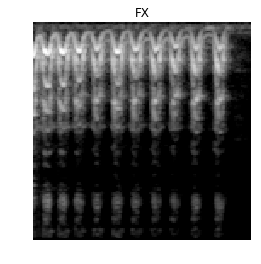

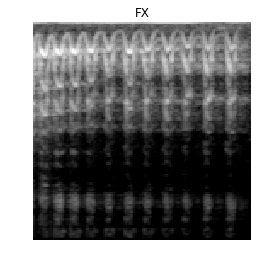

In [195]:
fxch = AudioEffectsChain().reverb()
#fxch = AudioEffectsChain().reverb(reverberance=50, hf_damping=50, room_scale=100, stereo_depth=100, pre_delay=20, wet_gain=0, wet_only=False)
fxch = AudioEffectsChain().reverb(reverberance=0)


#errors fxch = AudioEffectsChain().vol(2)#, type='amplitude', limiter_gain=0.5)
#fxch = AudioEffectsChain().pitch(1)#, use_tree=False, segment=82, search=14.68, overlap=12)
#fxch = AudioEffectsChain().pitch(-200)#, use_tree=False, segment=82, search=14.68, overlap=12)
        
aud_array_fx = fxch(aud_array)



#########
# Noise

aud_array_fx = aud_array + np.cumsum(np.random.normal(loc=0.0, scale=0.0003, size=aud_array.shape))

#reverb
aud_array_fx = fxch(aud_array_fx)


#########

# Smoothing array for background noise
stub_int = int((global_sr / 5))
smooth_array = np.ones(aud_array.shape)
smooth_array[:stub_int] = np.sin(np.linspace((-0.5 * np.pi), (0.5 * np.pi), stub_int))
smooth_array[-stub_int:] = np.sin(np.linspace((-1.5 * np.pi), (-0.5 * np.pi), stub_int))            
smooth_array = (-smooth_array - 1) / -2

# Smooth edges background noise
aud_array_fx = aud_array_fx * smooth_array



display(Audio(data=aud_array, rate=global_sr))
display(Audio(data=aud_array_fx, rate=global_sr))
display(aud_array.shape)
display(aud_array_fx.shape)


#display(Audio(data=aud_array[-subset_len:], rate=global_sr))
#display(Audio(data=aud_array_fx[-subset_len:], rate=global_sr))
#display(aud_array[-subset_len:].shape)
#display(aud_array_fx[-subset_len:].shape)



spec_array = librosa.logamplitude(\
            librosa.feature.melspectrogram(aud_array, 
                                           sr=global_sr,
                                           n_mels=global_n_mels),
                              ref_power=1.0)[np.newaxis,:,:,
                                             np.newaxis]

# Left slice            
#spec_array = spec_array[:,:,:173,:]

shift_n = np.random.randint(0, (173 - 128 + 1))
print(shift_n)

plt.figure()
img = plt.imshow(spec_array[0,:,shift_n:(shift_n + 128),0], cmap='gray')
title = 'FX'
plt.title(title)            
plt.axis('off')

print(spec_array[0,:,shift_n:(shift_n + 128),0].shape)


##########

spec_array = librosa.logamplitude(\
            librosa.feature.melspectrogram(aud_array_fx, 
                                           sr=global_sr,
                                           n_mels=global_n_mels),
                              ref_power=1.0)[np.newaxis,:,:,
                                             np.newaxis]

# Left slice            
#spec_array = spec_array[:,:,:173,:]

shift_n = np.random.randint(0, (173 - 128 + 1))
print(shift_n)

plt.figure()
img = plt.imshow(spec_array[0,:,shift_n:(shift_n + 128),0], cmap='gray')
title = 'FX'
plt.title(title)            
plt.axis('off')

print(spec_array[0,:,shift_n:(shift_n + 128),0].shape)


In [187]:
shift_n = np.random.randint(0, (173 - 128 + 1))
print(shift_n)
(shift_n + 128) - shift_n

19


128

In [173]:
shift_n = np.random.randint(0, (173 - 128 + 1))

shift_n
(shift_n + 128)

39

In [104]:
45+128

173

In [ ]:
#Return random integers from low (inclusive) to high (exclusive).

In [89]:
173 - 128

45

In [63]:
aud_array.shape[0]

88200

65257

In [66]:
aud_array[:int(aud_array.shape[0] * 128/173)].shape

(65257,)

In [ ]:
# Import the package and create an audio effects chain function.
from pysndfx import AudioEffectsChain
apply_audio_effects = AudioEffectsChain()\
    .highshelf()\
    .reverb()\
    .phaser()\
    .delay()\
    .lowshelf()

#Then we can call the effects chain object with paths to audio files, or directly with NumPy ndarrays.

#infile = 'my_audio_file.wav'
#outfile = 'my_processed_audio_file.ogg'

infile = audio_path #'my_audio_file.wav'
#outfile = 'my_processed_audio_file.ogg'


# Apply phaser and reverb directly to an audio file.
#apply_audio_effects(infile, outfile)

# Or, apply the effects directly to a NumPy ndarray.
from librosa import load
x, sr = load(infile, sr=None)
y = apply_audio_effects(x)

# Apply the effects and return the results as a NumPy ndarray.
#y = apply_audio_effects(infile)

# Apply the effects to a NumPy ndarray but store the resulting audio to disk.
#apply_audio_effects(x, outfile)

In [ ]:
apply_audio_effects?

In [ ]:

apply_audio_effects = AudioEffectsChain().reverb()
audio_path_reverb = apply_audio_effects(audio_path)

In [ ]:
audio_path_reverb.shape

In [ ]:
aud_array.shape

In [ ]:
audio_path

In [ ]:
display(Audio(data=aud_array, rate=global_sr))
display(Audio(data=audio_path, rate=global_sr))

In [ ]:
display(Audio(data=x, rate=global_sr))
display(Audio(data=y, rate=global_sr))

In [ ]:
apply_audio_effects = AudioEffectsChain()\
    .reverb()\
#    .delay()\

#Then we can call the effects chain object with paths to audio files, or directly with NumPy ndarrays.

#infile = 'my_audio_file.wav'
#outfile = 'my_processed_audio_file.ogg'

#infile = audio_path #'my_audio_file.wav'

x, sr = librosa.load(audio_path, sr=global_sr)
y = apply_audio_effects(x)

display(Audio(data=x, rate=global_sr))
display(Audio(data=y, rate=global_sr))

In [ ]:
x

In [ ]:
display(Audio(data=aud_array, rate=global_sr))

In [ ]:
display(Audio(data=aud_array, rate=global_sr))

In [ ]:
aud_array.shape

In [22]:
Audio(data=aud_array, rate=global_sr)

In [34]:
apply_audio_effects = AudioEffectsChain()\
    .reverb()\
#    .delay()\

aud_array_fx = apply_audio_effects(aud_array)


apply_audio_effects_2 = AudioEffectsChain()\
    .reverb()\
    .delay()\

aud_array_fx_2 = apply_audio_effects_2(aud_array)

In [35]:
aud_array_fx.shape

(88200,)

In [36]:
aud_array_fx_2.shape

(167580,)

In [37]:
display(Audio(data=aud_array, rate=global_sr))
display(Audio(data=aud_array_fx, rate=global_sr))
display(Audio(data=aud_array_fx_2, rate=global_sr))

(-0.5, 172.5, 127.5, -0.5)

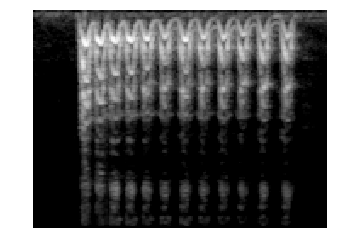

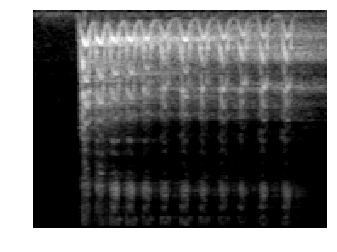

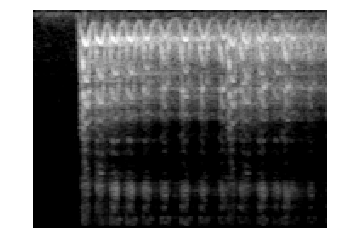

In [40]:
spec_array = librosa.logamplitude(\
            librosa.feature.melspectrogram(aud_array, 
                                           sr=global_sr,
                                           n_mels=global_n_mels),
                              ref_power=1.0)[np.newaxis,:,:,
                                             np.newaxis]

# Left slice            
spec_array = spec_array[:,:,:173,:]
#            print(spec_array.shape)

plt.figure()
img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
#title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: Left'
#plt.title(title)            
plt.axis('off')


##################
spec_array = librosa.logamplitude(\
            librosa.feature.melspectrogram(aud_array_fx, 
                                           sr=global_sr,
                                           n_mels=global_n_mels),
                              ref_power=1.0)[np.newaxis,:,:,
                                             np.newaxis]

# Left slice            
spec_array = spec_array[:,:,:173,:]
#            print(spec_array.shape)

plt.figure()
img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
#title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: Left'
plt.title(title)            
plt.axis('off')


##################
spec_array = librosa.logamplitude(\
            librosa.feature.melspectrogram(aud_array_fx_2, 
                                           sr=global_sr,
                                           n_mels=global_n_mels),
                              ref_power=1.0)[np.newaxis,:,:,
                                             np.newaxis]

# Left slice            
spec_array = spec_array[:,:,:173,:]
#            print(spec_array.shape)

plt.figure()
img = plt.imshow(spec_array[0,:,:,0], cmap='gray')
#title = 'ps: ' + str(ps) + '; ts: ' + str(ts) + '; slice: Left'
#plt.title(title)            
plt.axis('off')


##################

